# Figuring out the SDSS imaging pipeline 
to better understand observations and trying to be an astronomer...

In [1]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline 

from ChangTools.plotting import prettyplot
from ChangTools.plotting import prettycolors
from ChangTools.fitstables import mrdfits

In [2]:
from pydl.pydlutils.spheregroup import spherematch

/usr/local/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [59]:
# some constants
lsun = 3.846e33
pc = 3.085677581467e18 # cm
lightspeed = 2.998e18 # AA/s
to_cgs = lsun/(4.*np.pi * (pc * 10)**2)

## iSEDfit catalog

In [3]:
isedfit = mrdfits('../local/iGalPros/NSA_iSEDfit/nsa_v1_2_fsps_v2.4_miles_chab_charlot_sfhgrid01.fits.gz')

In [4]:
print sorted(isedfit.__dict__.keys())

['age', 'age_50', 'age_avg', 'age_err', 'av', 'av_50', 'av_avg', 'av_err', 'b100', 'b1000', 'b1000_50', 'b1000_avg', 'b1000_err', 'b100_50', 'b100_avg', 'b100_err', 'bestmaggies', 'bursttype', 'chi2', 'chunkindx', 'dec', 'delayed', 'dtburst', 'ewniiha', 'ewniiha_50', 'ewniiha_avg', 'ewniiha_err', 'ewoii', 'ewoii_50', 'ewoii_avg', 'ewoii_err', 'ewoiiihb', 'ewoiiihb_50', 'ewoiiihb_avg', 'ewoiiihb_err', 'fburst', 'isedfit_id', 'ivarmaggies', 'maggies', 'modelindx', 'mstar', 'mstar_50', 'mstar_avg', 'mstar_err', 'mu', 'mu_50', 'mu_avg', 'mu_err', 'nburst', 'nlyc', 'oiiihb', 'oiiihb_50', 'oiiihb_avg', 'oiiihb_err', 'ra', 'sfr', 'sfr100', 'sfr100_50', 'sfr100_avg', 'sfr100_err', 'sfr_50', 'sfr_avg', 'sfr_err', 'sfrage', 'sfrage_50', 'sfrage_avg', 'sfrage_err', 'tau', 'tau_50', 'tau_avg', 'tau_err', 'tburst', 'totalmass', 'totalmass_err', 'trunctau', 'z', 'zmetal', 'zmetal_50', 'zmetal_avg', 'zmetal_err']


## NSA catalog

In [5]:
nsa = mrdfits('../local/iGalPros/catalogs/nsa_v0_1_2.fits')
print sorted(nsa.__dict__.keys())

['absmag', 'ahdew', 'ahdewerr', 'ahgew', 'ahgewerr', 'aid', 'amivar', 'asymmetry', 'av', 'b1000', 'b300', 'ba50', 'ba90', 'bastokes', 'camcol', 'clumpy', 'coeff', 'd4000', 'd4000err', 'dec', 'deccat', 'dflags', 'dversion', 'extinction', 'fa', 'faerr', 'fiberflux', 'fiberflux_ivar', 'fiberid', 'field', 'haew', 'haewerr', 'haflux', 'hafluxerr', 'havmeas', 'havmerr', 'hbew', 'hbewerr', 'hbflux', 'hbfluxerr', 'hbvmeas', 'hbvmerr', 'ialfalfa', 'iauname', 'ined', 'isdss', 'isixdf', 'itwodf', 'izcat', 'kcoeff', 'kcorrect', 'mag', 'mass', 'mets', 'mjd', 'mtol', 'n2ew', 'n2ewerr', 'n2flux', 'n2fluxerr', 'n2vmeas', 'n2vmerr', 'ne3ew', 'ne3ewerr', 'ne5ew', 'ne5ewerr', 'nmgy', 'nmgy_ivar', 'nprof', 'nsaid', 'o1ew', 'o1ewerr', 'o1flux', 'o1fluxerr', 'o1vmeas', 'o1vmerr', 'o2ew', 'o2ewerr', 'o2flux', 'o2fluxerr', 'o2vmeas', 'o2vmerr', 'o3ew', 'o3ewerr', 'o3flux', 'o3fluxerr', 'o3vmeas', 'o3vmerr', 'objno', 'ok', 'petroflux', 'petroflux_ivar', 'petroth50', 'petroth90', 'petrotheta', 'phi50', 'phi90',

## Question 1: 
How are the maggies from iSEDfit processed from VAGC? We care because iSEDfit maggies are what's used by iSEDfit to fit photometry. 

Here's how we're going to answer this question, 
- Randomly select iSEDfit galaxies
- Cross-match them in VAGc
- Put VAGC photometry into expected pipeline
- Compare output from pipeline to iSEDfit maggies

In [6]:
# Random iSEDfit galaxies
ised_ids = [53999, 18965, 81806]
ised_gals = [{} for i in range(len(ised_ids))]

for i, gal_dict in enumerate(ised_gals): 
    for key in isedfit.__dict__.keys(): 
        gal_dict[key] = getattr(isedfit, key)[ised_ids[i]]

In [7]:
# cross-match using spherematch onto NSA catalog
match_nsa = spherematch(nsa.ra, nsa.dec, # NSA catalog
                        np.array([gd['ra'] for gd in ised_gals]), np.array([gd['dec'] for gd in ised_gals]),  # random galaxies
                        0.000833333) # 3 arcsec

In [8]:
# store cross-matched NSA data onto ised dictionary
for i, gal_dict in enumerate(ised_gals): 
    nsa_dict = {} 
    for key in nsa.__dict__.keys(): 
        nsa_dict[key] = getattr(nsa, key)[match_nsa[0][list(match_nsa[1]).index(i)]]
    
    gal_dict['nsa_dict'] = nsa_dict

In [9]:
for i_gal in range(len(ised_gals)): 
    print 'maggies used in iSEDfit: (nMgy)'
    print ised_gals[i_gal]['maggies'][2:]*1e9
    print 'fluxes from NSA...'
    print '      nmgy ', ised_gals[i_gal]['nsa_dict']['nmgy'][2:]
    for key in ised_gals[i_gal]['nsa_dict'].keys(): 
        if key in ['sersicflux', 'fiberflux', 'petroflux']: 
            print '      ', key,' ', ised_gals[i_gal]['nsa_dict'][key][2:]
    print '================================================='

maggies used in iSEDfit: (nMgy)
[  42.50177002  111.72774506  168.66938782  210.47738647  258.04071045]
fluxes from NSA...
      nmgy  [  42.50177002  111.72774506  168.66938782  210.47738647  258.04071045]
       sersicflux   [  37.88815689  106.37458801  162.9631958   208.94824219  261.51831055]
       fiberflux   [  8.86465931  27.19680977  41.89001465  54.61552429  64.24524689]
       petroflux   [  41.26671219   97.68169403  150.71589661  193.11863708  234.78257751]
maggies used in iSEDfit: (nMgy)
[  183.00810242  1106.93701172  2788.94702148  4411.60742188  6293.30712891]
fluxes from NSA...
      nmgy  [  183.00810242  1106.93701172  2788.94702148  4411.60742188  6293.30712891]
       sersicflux   [  167.21408081  1073.19140625  2730.27832031  4423.46337891  6423.39160156]
       fiberflux   [  21.30714035  141.94769287  374.56152344  619.52850342  905.06689453]
       petroflux   [  176.33511353   918.1293335   2041.94445801  3229.81030273  4357.08300781]
maggies used in iSEDfit

## maggies used in iSEDfit == NSA_data['nmgy']

## Question 2: 
How do the fiber fluxes compare to the AB fluxes

In [10]:
import fsps

In [11]:
# Lambda_SDSS
sdss_bands = fsps.find_filter('sdss')
L_sdss = [fsps.get_filter(sdss_band).lambda_eff/1.e4 for sdss_band in ['sdss_u', 'sdss_g', 'sdss_r', 'sdss_i', 'sdss_z']]

[ 1.08518434  1.0619967   1.04459202  1.03363383  1.02373171]
0.245663
[ 1.05875981  1.04290736  1.03093982  1.02337408  1.01651669]
0.140902
[ 1.23336947  1.1668781   1.11843944  1.08858252  1.06202602]
0.178348


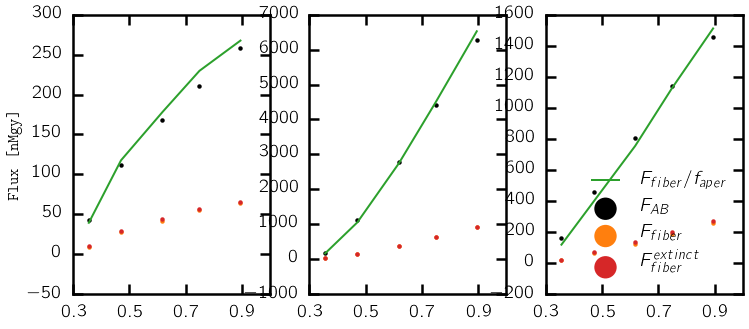

In [28]:
prettyplot()
pretty_colors = prettycolors()

fig = plt.figure(figsize=(12, 5))
for i_gal in range(len(ised_gals)): 
    sub = fig.add_subplot(1, 3, i_gal+1)
    sub.scatter(L_sdss, ised_gals[i_gal]['nsa_dict']['nmgy'][2:], c='k', lw=0, label='$F_{AB}$')
    # fiber flux
    sub.scatter(L_sdss, ised_gals[i_gal]['nsa_dict']['fiberflux'][2:], c=pretty_colors[3], lw=0, label='$F_{fiber}$')

    # extinction corrected fiber flux
    f_extinct = 10**(0.4*ised_gals[i_gal]['nsa_dict']['extinction'][2:])
    print f_extinct
    sub.scatter(L_sdss, ised_gals[i_gal]['nsa_dict']['fiberflux'][2:] * f_extinct, 
                c=pretty_colors[7], lw=0, label='$F_{fiber}^{extinct}$')
    
    f_aperture =  ised_gals[i_gal]['nsa_dict']['fiberflux'][-1]/ised_gals[i_gal]['nsa_dict']['sersicflux'][-1]    
    print f_aperture
    
    sub.plot(L_sdss, ised_gals[i_gal]['nsa_dict']['fiberflux'][2:] * f_extinct / f_aperture,
             c=pretty_colors[5], lw=2, label='$F_{fiber} / f_{aper}$')

    # x-axis
    sub.set_xlim([0.3, 1.0])
    sub.set_xticks([0.3, 0.5, 0.7, 0.9])
    # y-axis 
    if i_gal == 0: 
        sub.set_ylabel('Flux [nMgy]')
sub.legend(loc='lower right', scatterpoints=1)

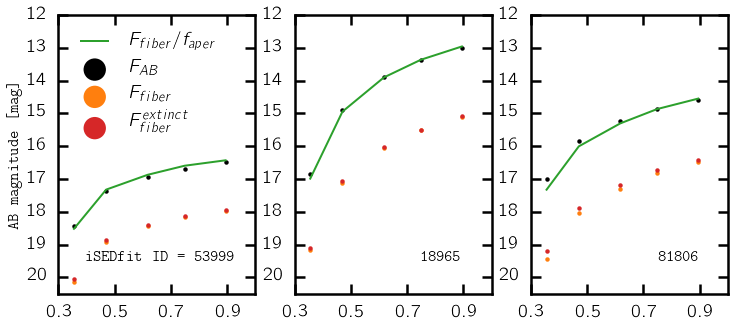

In [40]:
prettyplot()
pretty_colors = prettycolors()

fig = plt.figure(figsize=(12, 5))
for i_gal in range(len(ised_gals)): 
    sub = fig.add_subplot(1, 3, i_gal+1)
    sub.scatter(L_sdss, -2.5 * np.log10(ised_gals[i_gal]['nsa_dict']['nmgy'][2:]*1e-9), c='k', lw=0, label='$F_{AB}$')
    # fiber flux
    sub.scatter(L_sdss, -2.5 * np.log10(ised_gals[i_gal]['nsa_dict']['fiberflux'][2:]*1e-9), 
                c=pretty_colors[3], lw=0, label='$F_{fiber}$')
    
    # extinction corrected fiber flux
    f_extinct = 10**(0.4*ised_gals[i_gal]['nsa_dict']['extinction'][2:])
    sub.scatter(L_sdss, -2.5 * np.log10(ised_gals[i_gal]['nsa_dict']['fiberflux'][2:]*1e-9 * f_extinct), 
                c=pretty_colors[7], lw=0, label='$F_{fiber}^{extinct}$')
    
    f_aperture = ised_gals[i_gal]['nsa_dict']['fiberflux'][-1]/ised_gals[i_gal]['nsa_dict']['sersicflux'][-1]    
    
    sub.plot(L_sdss, -2.5 * np.log10(ised_gals[i_gal]['nsa_dict']['fiberflux'][2:]*1e-9 * f_extinct / f_aperture),
             c=pretty_colors[5], lw=2, label='$F_{fiber} / f_{aper}$')
    # x-axis
    sub.set_xlim([0.3, 1.0])
    sub.set_xticks([0.3, 0.5, 0.7, 0.9])
    # y-axis 
    sub.set_ylim([20.5, 12])
    if i_gal == 0: 
        sub.set_ylabel('AB magnitude [mag]')
        sub.legend(loc='upper left', scatterpoints=1)
        sub.text(0.4, 19.5, 'iSEDfit ID = '+str(ised_ids[i_gal]))
    else: 
        sub.text(0.75, 19.5, str(ised_ids[i_gal]))

In [41]:
print ised_gals[2]['ra'], ised_gals[2]['dec']

122.343339292 17.7657421047


## Question 3: 
How do the fiber fluxes compare to SDSS SpecObjAll spectra?

In [42]:
from ChangTools.fitstables import mrdfits

In [49]:
# cosmology imports
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

In [62]:
# load in galaxy spectra
for i_gal in range(len(ised_gals)): 
    spec = mrdfits('../local/iGalProS/gal'+str(i_gal+1)+'.fits')

    ised_gals[i_gal]['lambda'] = (10**spec.loglam)/1e4
    ised_gals[i_gal]['spectra_sdss'] = spec.flux

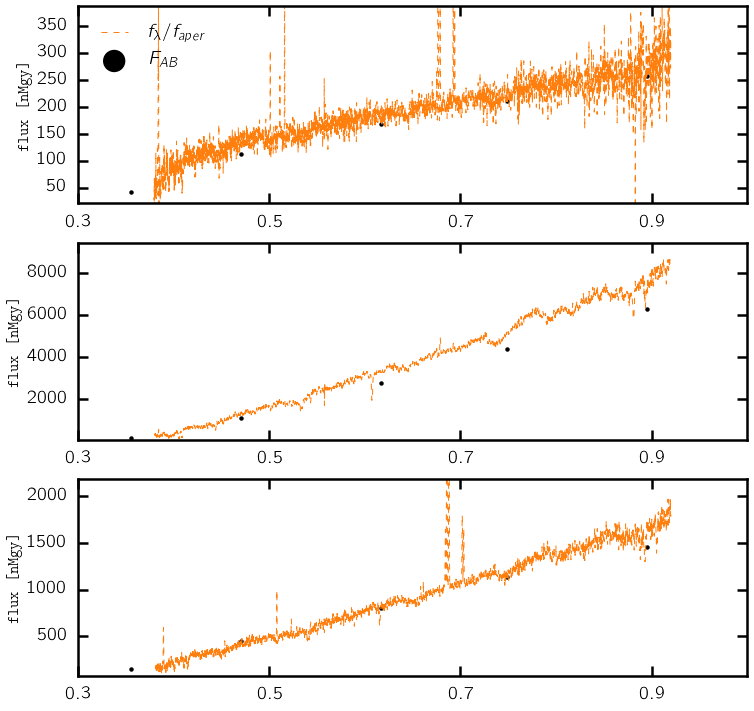

In [79]:
prettyplot()
pretty_colors = prettycolors()

fig = plt.figure(figsize=(12, 12))
for i_gal in range(len(ised_gals)): 
    sub = fig.add_subplot(3, 1, i_gal+1)
    # observed spectra in units of nMgys
    flux = ised_gals[i_gal]['spectra_sdss'] * (ised_gals[i_gal]['lambda'] * 1e4)**2 / lightspeed / 1e3 / (3631 * 1e-26) * 1e-17 * 1e9
    #sub.plot(ised_gals[i_gal]['lambda'], flux, c=pretty_colors[3], lw=2, label='spectra')
    
    f_aperture = ised_gals[i_gal]['nsa_dict']['fiberflux'][-1]/ised_gals[i_gal]['nsa_dict']['sersicflux'][-1]    
    
    sub.plot(ised_gals[i_gal]['lambda'], flux / f_aperture, c=pretty_colors[3], lw=1, ls='--', label='$f_\lambda / f_{aper}$')
    
    sub.scatter(L_sdss, ised_gals[i_gal]['nsa_dict']['nmgy'][2:], c='k', lw=0, label='$F_{AB}$')

    # x-axis
    sub.set_xlim([0.3, 1.0])
    sub.set_xticks([0.3, 0.5, 0.7, 0.9])
    # y-axis 
    sub.set_ylim([0.5*ised_gals[i_gal]['nsa_dict']['nmgy'][2:].min(), 1.5*ised_gals[i_gal]['nsa_dict']['nmgy'][2:].max()])
    sub.set_ylabel('flux [nMgy]')
    if i_gal == 0: 
        sub.legend(loc='upper left', scatterpoints=1)
        #sub.text(0.4, 19.5, 'iSEDfit ID = '+str(ised_ids[i_gal]))
    else:
        pass
        #sub.text(0.75, 19.5, str(ised_ids[i_gal]))

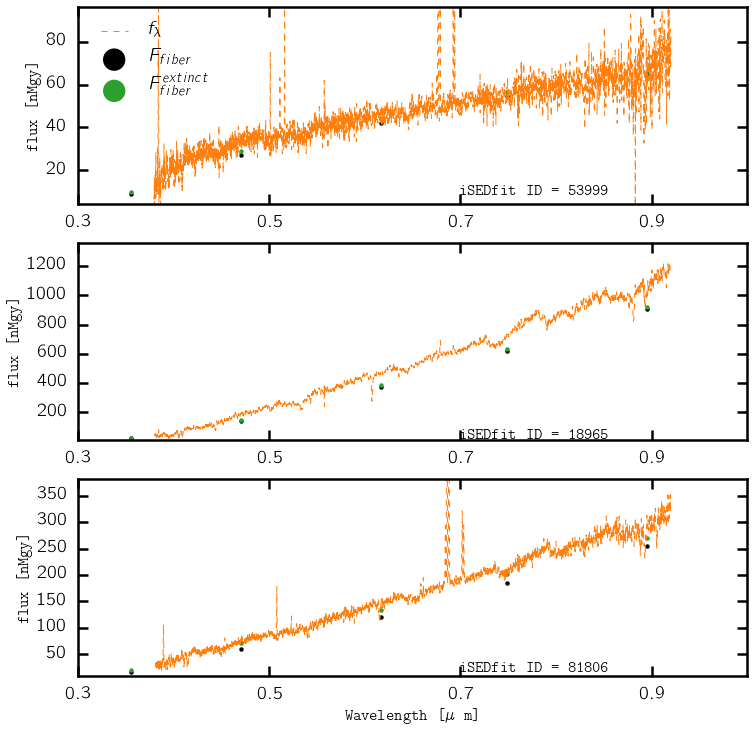

In [84]:
prettyplot()
pretty_colors = prettycolors()

fig = plt.figure(figsize=(12, 12))
for i_gal in range(len(ised_gals)): 
    sub = fig.add_subplot(3, 1, i_gal+1)
    # observed spectra in units of nMgys
    flux = ised_gals[i_gal]['spectra_sdss'] * (ised_gals[i_gal]['lambda'] * 1e4)**2 / lightspeed / 1e3 / (3631 * 1e-26) * 1e-17 * 1e9
    sub.plot(ised_gals[i_gal]['lambda'], flux, c=pretty_colors[3], lw=1, ls='--', label='$f_\lambda$')
    
    sub.scatter(L_sdss, ised_gals[i_gal]['nsa_dict']['fiberflux'][2:], 
                c='k', lw=0, label='$F_{fiber}$')
    
    # extinction corrected fiber flux
    f_extinct = 10**(0.4*ised_gals[i_gal]['nsa_dict']['extinction'][2:])
    sub.scatter(L_sdss, ised_gals[i_gal]['nsa_dict']['fiberflux'][2:] * f_extinct, 
                c=pretty_colors[5], lw=0, label='$F_{fiber}^{extinct}$')
    
    # x-axis
    sub.set_xlim([0.3, 1.0])
    sub.set_xticks([0.3, 0.5, 0.7, 0.9])
    # y-axis 
    sub.set_ylim([0.5*ised_gals[i_gal]['nsa_dict']['fiberflux'][2:].min(), 1.5*ised_gals[i_gal]['nsa_dict']['fiberflux'][2:].max()])
    sub.set_ylabel('flux [nMgy]')
    sub.text(0.7, ised_gals[i_gal]['nsa_dict']['fiberflux'][2:].min(), 'iSEDfit ID = '+str(ised_ids[i_gal]))
    if i_gal == 0: 
        sub.legend(loc='upper left', scatterpoints=1)
sub.set_xlabel('Wavelength [$\mu$ m]')